# Env Setting

In [1]:
import sys 
# sys.path.clear()
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\python36.zip')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\DLLs')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib\\site-packages')
sys.path.insert(0, '')

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.0.0


In [3]:
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
from sklearn.preprocessing import normalize
import datetime
import json
import pandas as pd
import time
import yaml
import scipy.sparse as sparse
from ast import literal_eval

import numpy as np
import matplotlib.pyplot as plt

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge
from sklearn.utils.extmath import randomized_svd

# Loading data

In [5]:
# Load Original Data
df_train = pd.read_csv('../../data/yelp/Train.csv',encoding='latin-1')
df_valid = pd.read_csv('../../data/yelp/Valid.csv',encoding='latin-1')
df_test = pd.read_csv('../../data/yelp/Test.csv',encoding='latin-1')

In [6]:
keyphrases = pd.read_csv('../../data/yelp/KeyPhrases.csv')['Phrases'].tolist()
keyphrase_popularity = np.loadtxt('../data/yelp/'+'keyphrase_popularity.txt', dtype=int)

In [7]:
# Load U-I Data 
rtrain = load_npz("../../data/yelp/Rtrain.npz")
rvalid = load_npz("../../data/yelp/Rvalid.npz")
rtest = load_npz("../../data/yelp/Rtest.npz")

In [8]:
# Load user/item keyphrase data
U_K = load_npz("../../data/yelp/U_K.npz")
I_K = load_npz("../../data/yelp/I_K.npz")

# Forward Models

In [9]:
# Models
from sklearn.metrics.pairwise import cosine_similarity
def train(matrix_train):
    similarity = cosine_similarity(X=matrix_train, Y=None, dense_output=True)
    return similarity

def get_I_K(df, row_name = 'ItemIndex', shape = (3668,75)):
    rows = []
    cols = []
    vals = []
    for i in tqdm(range(df.shape[0])):
        key_vector = literal_eval(df['keyVector'][i])
        rows.extend([df[row_name][i]]*len(key_vector)) ## Item index
        cols.extend(key_vector) ## Keyword Index
        vals.extend(np.array([1]*len(key_vector)))
    return csr_matrix((vals, (rows, cols)), shape=shape)



def prediction(prediction_score, topK, matrix_Train):

    prediction = []

    for user_index in tqdm(range(matrix_Train.shape[0])):
        vector_u = prediction_score[user_index]
        vector_train = matrix_Train[user_index]
        if len(vector_train.nonzero()[0]) > 0:
            vector_predict = sub_routine(vector_u, vector_train, topK=topK)
        else:
            vector_predict = np.zeros(topK, dtype=np.float32)

        prediction.append(vector_predict)

    return np.vstack(prediction)


def sub_routine(vector_u, vector_train, topK=500):

    train_index = vector_train.nonzero()[1]

    vector_u = vector_u

    candidate_index = np.argpartition(-vector_u, topK+len(train_index))[:topK+len(train_index)]
    vector_u = candidate_index[vector_u[candidate_index].argsort()[::-1]]
    vector_u = np.delete(vector_u, np.isin(vector_u, train_index).nonzero()[0])

    return vector_u[:topK]


In [10]:
def predict(matrix_train, k, similarity, item_similarity_en = False):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    """
    prediction_scores = []
    
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    for user_index in tqdm(range(matrix_train.shape[0])):
        # Get user u's prediction scores to all users
        vector_u = similarity[user_index]

        # Get closest K neighbors excluding user u self
        similar_users = vector_u.argsort()[::-1][1:k+1]
        # Get neighbors similarity weights and ratings
        similar_users_weights = similarity[user_index][similar_users]
        similar_users_ratings = matrix_train[similar_users].toarray()

        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]

        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    
    return res

def predict_vector(user_index, matrix_train, k, similarity):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    get only user_index row
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    return np.sum(prediction_scores_u, axis=0)
    

# Eval Models

In [11]:
# Evluation 
def recallk(vector_true_dense, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_true_dense)

def precisionk(vector_predict, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_predict)


def average_precisionk(vector_predict, hits, **unused):
    precisions = np.cumsum(hits, dtype=np.float32)/range(1, len(vector_predict)+1)
    return np.mean(precisions)


def r_precision(vector_true_dense, vector_predict, **unused):
    vector_predict_short = vector_predict[:len(vector_true_dense)]
    hits = len(np.isin(vector_predict_short, vector_true_dense).nonzero()[0])
    return float(hits)/len(vector_true_dense)


def _dcg_support(size):
    arr = np.arange(1, size+1)+1
    return 1./np.log2(arr)


def ndcg(vector_true_dense, vector_predict, hits):
    idcg = np.sum(_dcg_support(len(vector_true_dense)))
    dcg_base = _dcg_support(len(vector_predict))
    dcg_base[np.logical_not(hits)] = 0
    dcg = np.sum(dcg_base)
    return dcg/idcg


def click(hits, **unused):
    first_hit = next((i for i, x in enumerate(hits) if x), None)
    if first_hit is None:
        return 5
    else:
        return first_hit/10


def evaluate(matrix_Predict, matrix_Test, metric_names =['R-Precision', 'NDCG', 'Precision', 'Recall', 'MAP'], atK = [5, 10, 15, 20, 50], analytical=False):
    """
    :param matrix_U: Latent representations of users, for LRecs it is RQ, for ALSs it is U
    :param matrix_V: Latent representations of items, for LRecs it is Q, for ALSs it is V
    :param matrix_Train: Rating matrix for training, features.
    :param matrix_Test: Rating matrix for evaluation, true labels.
    :param k: Top K retrieval
    :param metric_names: Evaluation metrics
    :return:
    """
    global_metrics = {
        "R-Precision": r_precision,
        "NDCG": ndcg,
        "Clicks": click
    }

    local_metrics = {
        "Precision": precisionk,
        "Recall": recallk,
        "MAP": average_precisionk
    }

    output = dict()

    num_users = matrix_Predict.shape[0]

    for k in atK:

        local_metric_names = list(set(metric_names).intersection(local_metrics.keys()))
        results = {name: [] for name in local_metric_names}
        topK_Predict = matrix_Predict[:, :k]

        for user_index in tqdm(range(topK_Predict.shape[0])):
            vector_predict = topK_Predict[user_index]
            if len(vector_predict.nonzero()[0]) > 0:
                vector_true = matrix_Test[user_index]
                vector_true_dense = vector_true.nonzero()[1]
                hits = np.isin(vector_predict, vector_true_dense)

                if vector_true_dense.size > 0:
                    for name in local_metric_names:
                        results[name].append(local_metrics[name](vector_true_dense=vector_true_dense,
                                                                 vector_predict=vector_predict,
                                                                 hits=hits))

        results_summary = dict()
        if analytical:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = results[name]
        else:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = (np.average(results[name]),
                                                              1.96*np.std(results[name])/np.sqrt(num_users))
        output.update(results_summary)

    global_metric_names = list(set(metric_names).intersection(global_metrics.keys()))
    results = {name: [] for name in global_metric_names}

    topK_Predict = matrix_Predict[:]

    for user_index in tqdm(range(topK_Predict.shape[0])):
        vector_predict = topK_Predict[user_index]

        if len(vector_predict.nonzero()[0]) > 0:
            vector_true = matrix_Test[user_index]
            vector_true_dense = vector_true.nonzero()[1]
            hits = np.isin(vector_predict, vector_true_dense)

            # if user_index == 1:
            #     import ipdb;
            #     ipdb.set_trace()

            if vector_true_dense.size > 0:
                for name in global_metric_names:
                    results[name].append(global_metrics[name](vector_true_dense=vector_true_dense,
                                                              vector_predict=vector_predict,
                                                              hits=hits))

    results_summary = dict()
    if analytical:
        for name in global_metric_names:
            results_summary[name] = results[name]
    else:
        for name in global_metric_names:
            results_summary[name] = (np.average(results[name]), 1.96*np.std(results[name])/np.sqrt(num_users))
    output.update(results_summary)

    return output



# Forward Initial Prediction

## User-Item KNN

In [11]:
similarity = normalize(train(rtrain))
user_item_prediction_score = predict(rtrain, 100, similarity, item_similarity_en= False)
user_item_predict = prediction(user_item_prediction_score, 50, rtrain)
user_item_res = evaluate(user_item_predict, rtest)

100%|████████████████████████████████████████████████████████████████████████████| 2343/2343 [00:00<00:00, 4166.57it/s]


In [12]:
# k = 100 
user_item_res

{'MAP@10': (0.06333952750429245, 0.00455145183026277),
 'MAP@15': (0.05872249612550844, 0.0038121823597348156),
 'MAP@20': (0.055196280875748356, 0.003345258771111864),
 'MAP@5': (0.06940666362391602, 0.0060646277121995185),
 'MAP@50': (0.04436838784245958, 0.0022020570312340938),
 'NDCG': (0.09071795198195, 0.003803970590016347),
 'Precision@10': (0.05330899132816066, 0.0032544740534870857),
 'Precision@15': (0.04698006998326487, 0.0025622684368576416),
 'Precision@20': (0.043336376083979916, 0.002222006808632301),
 'Precision@5': (0.06462802373345505, 0.004754606217931856),
 'Precision@50': (0.032889091738931994, 0.0014317314500480152),
 'R-Precision': (0.048464138894968055, 0.0027869069242192506),
 'Recall@10': (0.04269615369598775, 0.0027831077562657665),
 'Recall@15': (0.05562887733868642, 0.0031389991916236284),
 'Recall@20': (0.0677664821917642, 0.003424484045821138),
 'Recall@5': (0.026408137823500974, 0.002191309117794643),
 'Recall@50': (0.12696642809611336, 0.004824188397130

## Latent Similarity Matrix Learned with Linear Regression¶

In [12]:
# Training 
X = normalize(U_K.todense())
y = normalize(train(rtrain))
clf = Ridge(alpha=0.1).fit(X, y) # Optimality at L2 regularization = 0.1
lr_similarity = clf.predict(np.array(X))

In [ ]:
# Prediciting
similarity = lr_similarity
lr_prediction_score = predict(rtrain, 100, similarity, item_similarity_en= False)
lr_predict = prediction(lr_prediction_score, 50, rtrain)
lr_res = evaluate(lr_predict, rtest)

In [ ]:
# k = 100
lr_res

# Critiquing 

In [13]:
# One hot encoding of critiquing
def get_critiqued_UK(user_keyphrase_frequency,user_index,critiqued_keyphrase):
    """
    user_keyphrase_frequency is the U_K matrix (csr sparse matrix)
    return the one-hot encoding of the critique
    """
    U_K_cp = user_keyphrase_frequency.copy()
    U_K_cp[user_index] = 0
    U_K_cp[user_index,critiqued_keyphrase] = 1
    return U_K_cp

def project_one_hot_encoding(reg, user_keyphrase_frequency,user_index = 0,critiqued_keyphrase = 0, normalize_en = True):
    """
    Return the projection on user_sim space from one-hot encoding of critiqued keyphrase
    The res[user_index] should be target embedding row
    """
    critiqued_matrix = get_critiqued_UK(user_keyphrase_frequency, user_index, critiqued_keyphrase)
    res = reg.predict(critiqued_matrix)
    if normalize_en:
        res = normalize((res))
    return res

In [14]:
def get_initial_predictions(X = normalize(U_K.todense()), y = normalize(train(rtrain)),
                            matrix_Train = rtrain, k = 100):
    clf = Ridge(alpha=0.1).fit(X, y)
    similarity = normalize(train(matrix_Train))
    user_item_prediction_score = predict(matrix_Train, k, similarity, item_similarity_en= False)
    return user_item_prediction_score, clf
def get_valid_keyphrases(keyphrase_freq,top_recommendations,item = None,threshold=50,mutiple_keyphrases_en = False, top_items = None):
    """
    Wrapper function to get either top 1 or top n keyphrases
    """
    if mutiple_keyphrases_en:
        top_keyphrases = []
        for item in top_items:
            top_keyphrases.extend(get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations,item,threshold=threshold))
        return np.ravel(list(set(top_keyphrases))) # remove duplicate and reformat to np array
    else:
        return get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations,item,threshold=threshold)

def get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations, item,threshold=50):
    """
    Get keyphrases of item that make sense
    E.g. if the item has fewer than threshold=50 keyphrases, get all of them
    otherwise get top 50 keyphrases
    """
    keyphrase_length = len(keyphrase_freq[item].nonzero()[1])
    if keyphrase_length<threshold:
        return keyphrase_freq[item].nonzero()[1]
    else:
        keyphrases = np.ravel(keyphrase_freq[top_recommendations[0]].todense())
        top_keyphrases = np.argsort(keyphrases)[::-1][:threshold]
        return top_keyphrases
    
def predict_vector(user_index, matrix_train, k, similarity, with_keyphrase = False, 
                   keyphrase_freq = None, critiqued_keyphrase = None, alpha = 0):
    """
    get only user_index row
    if with_keyphrase = True, then penalize items without critiqued_keyphrase to alpha (default = 0)
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    if with_keyphrase == False:
        return np.sum(prediction_scores_u, axis=0)
    
    # Only Predict items with critiqued_keyphrase 
    else:
        prediction_scores = np.sum(prediction_scores_u, axis=0)
#         print (prediction_scores)
        #penalize items without critiqued keyphrase
        items_with_keyphrase = np.ravel(keyphrase_freq.T[critiqued_keyphrase].nonzero()[1])
#         print (items_with_keyphrase)
        #Return the unique values in ar1 that are not in ar2.
        items_without_keyphrase = np.setdiff1d(np.arange(matrix_train.shape[1]), items_with_keyphrase)
        prediction_scores[items_without_keyphrase] = alpha # penalize
        return prediction_scores
#         print (prediction_scores)
#         return prediction_scores/sum(prediction_scores)

    
def get_initial_prediction(user,X = normalize(U_K.todense()), y = normalize(train(rtrain)),
                            matrix_Train = rtrain, k = 100):
    """
    Get the initial knn predictions before critiquing pipelines
    get the linear regression model for critiquing embedding (W_2)
    get the initial user similarity matrix 
    k here is the parameter for KNN
    """
    clf = Ridge(alpha=0.1).fit(X, y)
    similarity = normalize(train(matrix_Train))
    user_item_prediction_score = predict_vector(user, matrix_Train, k, similarity)
    return user_item_prediction_score, clf



In [15]:
# For keyphrase selecting method # 3 "diff" 
def get_item_keyphrase_freq(keyphrase_freq,item):
    """
    Get item's keyphrase frequency 
    """
    count = keyphrase_freq[item].todense()
    return count/np.sum(count)

In [16]:
# Utility function for getting restaurant info from ItemIndex
def get_business_df(path = "../../data/yelp/business.json" ):
    with open(path,encoding="utf8") as json_file:
        data = json_file.readlines()
        data = list(map(json.loads, data))
    df = pd.DataFrame(data)
    
    return df

def get_restaurant_info(business_df, business_id, name = True, review_count = True, stars = True ):
    output_list = {}
    row_idx = int(business_df.index[business_df['business_id'] == business_id].tolist()[0])
    if name == True:
        output_list['name'] = business_df['name'][row_idx].encode('utf-8').strip()
    if review_count == True:
        output_list['review_count'] = business_df['review_count'][row_idx]
    if stars == True:
        output_list['stars'] = business_df['stars'][row_idx] 
    return output_list

# def get_businessid_from_Itemindex(ItemIndex_list, itemindex):
#     return ItemIndex_list['business_id'].tolist()[itemindex]

def get_restaurant_name(df_train, business_df, ItemIndex):
    rows = np.where(df_train['ItemIndex'] == ItemIndex)
    if len(rows)!= 0:
        business_id = df_train.loc[rows[0][0]]['business_id']
        item_info = get_restaurant_info(business_df, business_id)
        return item_info['name']
    return "NOT_FOUND"

In [17]:
def get_keyphrase_popularity(df,keyphrases):
    """
    Get keyphrase popularity (count) from dataframe
    """
    keyphrase_popularity = np.zeros(len(keyphrases)) #initialize
    for i in range(len(df)):
        keyphrase_vector = literal_eval(df['keyVector'][i])
        keyphrase_popularity[keyphrase_vector] += 1 # count
    return keyphrase_popularity

# PLREC

In [189]:
def inhour(elapsed):
    return time.strftime('%H:%M:%S', time.gmtime(elapsed))

def plrec(matrix_train, iteration=4, lamb=80, rank=200, seed=1):
    """
    Function used to achieve generalized projected lrec w/o item-attribute embedding
    :param matrix_train: user-item matrix with shape m*n
    :param iteration: number of power iterations in randomized svd
    :param lamb: parameter of penalty
    :param rank: latent dimension size
    :param seed: the seed of the pseudo random number generator to use when shuffling the data
    :return: prediction in sparse matrix
    """
    print ("Randomized SVD")
    start_time = time.time()
    P, sigma, Qt = randomized_svd(matrix_train,
                                  n_components=rank,
                                  n_iter=iteration,
                                  random_state=seed)

    RQ = matrix_train.dot(sparse.csc_matrix(Qt.T*np.sqrt(sigma)))

    print("Elapsed: {}".format(inhour(time.time() - start_time)))

    print ("Closed-Form Linear Optimization")
    start_time = time.time()
    pre_inv = RQ.T.dot(RQ) + lamb * sparse.identity(rank, dtype=np.float32)
    inverse = sparse.linalg.inv(pre_inv.tocsc())
    Y = inverse.dot(RQ.T).dot(matrix_train)
    print("Elapsed: {}".format(inhour(time.time() - start_time)))

    return np.array(RQ.todense()), np.array(Y.todense()), None

def predict_vector(rating_vector, train_vector, remove_train=True):
    dim = len(rating_vector)
    candidate_index = np.argpartition(-rating_vector, dim-1)[:dim]
    prediction_items = candidate_index[rating_vector[candidate_index].argsort()[::-1]]
    
    if remove_train:
        return np.delete(prediction_items, np.isin(prediction_items, train_vector.nonzero()[1]).nonzero()[0])
    else:
        return prediction_items

    
    
def predict_scores(matrix_U, matrix_V, bias=None,
                   penalize = False,
                   keyphrase_freq = I_K, 
                   critiqued_keyphrase = 0, 
                   matrix_Train = rtrain,
                   alpha = 0):
    prediction = matrix_U.dot(matrix_V.T)
    # Penalize
    if penalize == True:
        items_with_keyphrase = np.ravel(keyphrase_freq.T[critiqued_keyphrase].nonzero()[1])
        items_without_keyphrase = np.setdiff1d(np.arange(matrix_Train.shape[1]), items_with_keyphrase)
        prediction[items_without_keyphrase] = alpha # penalize
    
    return prediction


In [54]:
predict_scores(matrix_U=RQ,
                                      matrix_V=Y).T[0]

array([0.02423235, 0.00822149, 0.06785218, ..., 0.        , 0.04487471,
       0.00032856], dtype=float32)

In [145]:
Y.shape

(2343, 200)

In [203]:
I_K[:1].nonzero()[1]

array([  1,   4,  29,  31,  35,  42,  43,  45,  49,  50,  81,  97, 104,
       107, 113, 135, 142, 148, 149, 150, 152, 153, 164, 167, 168, 171,
       174, 177, 183, 184, 185, 186, 213, 233])

In [206]:
list(set([1,1,2,3,4]))

[1, 2, 3, 4]

In [269]:
def get_all_affected_items(wanted_keyphrases,keyphrase_freq):
    res = []
    for keyphrase in wanted_keyphrases:
        items = np.ravel(keyphrase_freq.T[keyphrase].nonzero()[1])
        res.extend(items)
    return np.array(list(set(res)))
    
def select_only_wanted_keyphrase(top_recommendations, wanted_keyphrases, keyphrase_freq, matrix_Train = rtrain):
    all_items_with_keyphrases = get_all_affected_items(wanted_keyphrases,keyphrase_freq)
    affected_items = np.setdiff1d(np.arange(matrix_Train.shape[1]), all_items_with_keyphrases) # Get all other keyphrases
    top_recommendations[~np.in1d(top_recommendations, affected_items)]
    return top_recommendations

def pruning(prediction_score, 
           wanted_keyphrases_random, 
           top_recommendations, 
           keyphrase_freq, 
           matrix_Train = rtrain,
           alpha = 0):
    items_with_keyphrase = get_all_affected_items(wanted_keyphrases_random, keyphrase_freq)
    #Return the unique values in ar1 that are not in ar2.
    items_without_keyphrase = np.setdiff1d(np.arange(matrix_Train.shape[1]), items_with_keyphrase)
#     print (items_without_keyphrase)
    print (sum(prediction_score[items_without_keyphrase]))
    score = np.copy(prediction_score)
    score[items_without_keyphrase] = alpha # penalize
    return score

In [274]:
def single_step_critiquing_plrec(user = 2, 
                           keyphrase_length_threshold = 150, 
                           max_iteration_threshold = 5,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           keyphrases = keyphrases,
                           keyphrase_popularity = keyphrase_popularity, 
                           keyphrase_selection_method = 'random',
                           recommend_type = 'all',
                           lams = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                           reg = reg, Y = Y, RQt = RQt, Bias = Bias
                          ):
    """
    k: HR@k 
    keyphrase_length_threshold: limit the number of keyphrases in top recommended item
    keyphrase_selection_method: 'random': randomly select keyphrase from wanted_keyphrases
                                'pop': always select the most popular keyphrase in wanted_keyphrases
                                'diff': select the keyphrase with largest frequency difference between top recommended 
                                        item and target item.
    recommend_type: 'all': recommend all items
                    'upper' (only_with_critiqued_keyphrase): recommend items with only critiqued_keyphrase
    lam: modified_matrix = lam*origianl_matrix + (1-lam)*critiquing_embedding 
    """
    
    row['user_id'] = user
    print ('User ID ', user)
    
    # Set up (move to header line later)
    matrix_Train = rtrain
    matrix_Test = rtest
    keyphrase_freq = I_K
    num_items = rtrain.shape[1]
    max_wanted_keyphrase = 10 # for keyphrase_selection_method == "diff"
    initial_user_similarity_embedding = normalize(train(matrix_Train))
    
    # Get wanted items 
    candidate_items = matrix_Test[user].nonzero()[1]
    train_items = matrix_Train[user].nonzero()[1]
    wanted_items = np.setdiff1d(candidate_items, train_items)
    print ('wanted_items length: ',len(wanted_items))
    
    # Get initial forward prediction 
#     prediction_score,clf = get_initial_prediction(user, X = normalize(U_K.todense()), y = normalize(train(rtrain)),
#                             matrix_Train = rtrain, k = 100)
#     Y, RQt, Bias = plrec(matrix_Train,
#                     iteration = 10,
#                     lamb = 200,
#                     rank = 200)
#     RQ = RQt.T
#     reg = LinearRegression().fit(normalize(U_K), Y)
    prediction_score = predict_scores(matrix_U=RQ,
                                      matrix_V=Y,
                                      bias=Bias).T[user]
    # Get initial top recommended item(s)
    top_recommendations = np.argsort(prediction_score)[::-1]
    print ("Initial top recommendation index",top_recommendations[0])
    try:
        row['top_prediction_item_name'] = get_restaurant_name(df_train, business_df, top_recommendations[0])
    # in case we cannot get the restaurant name
    except: 
        row['top_prediction_item_name'] = 'CANNOT_FIND'
        print ('Cannot get restaurant name for ItemIndex: ', top_recommendations[0])
    
    
    # Get top recommended item's keyphrases
    top_item = top_recommendations[0] 
    top_recommend_keyphrases = get_valid_keyphrases(keyphrase_freq,
                                                    top_recommendations, 
                                                    item = top_item,
                                                    threshold=keyphrase_length_threshold,
                                                    mutiple_keyphrases_en = False, 
                                                    top_items = None)
    top_recommended_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = top_item)
    
    
    #####################################
    # For each item, do the critiquing
    
    #limit the item to only 10
    num_target_item = 0 # initialize item count
    
    for item in wanted_items:    
        print ('target_item: ', item)
        row['target_item'] = item
        try:
            row['item_name'] = get_restaurant_name(df_train, business_df, item)
        except:
            row['item_name'] = 'CANNOT_FIND'
            print ('Cannot get restaurant name for ItemIndex: ', item)

        # Get pre-critiquing rank
        initial_rank = np.where(item == np.argsort(prediction_score)[::-1])[0][0]
#         print ('target_item initial rank', int(initial_rank))
        row['pre_rank'] = int(initial_rank)

        # Get the target item's existing keyphrases
        item_keyphrases = keyphrase_freq[item].nonzero()[1]
        
        # For diff 
        target_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = item)
        diff_keyphrase_freq = target_keyphrase_freq - top_recommended_keyphrase_freq
        
        wanted_keyphrases_random = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
        wanted_keyphrases_pop = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
        wanted_keyphrases_diff = np.argsort(np.ravel(diff_keyphrase_freq))[::-1][:max_wanted_keyphrase]
        
        pruned_prediction_score = pruning(prediction_score, 
                                           wanted_keyphrases_random, 
                                           top_recommendations, 
                                           keyphrase_freq, 
                                           matrix_Train = rtrain)
        pure_pruning_rank = np.where(item == np.argsort(pruned_prediction_score)[::-1])[0][0]
        if pure_pruning_rank>initial_rank:
            pure_pruning_rank = initial_rank
        row['pure_pruning_rank'] = int(pure_pruning_rank)    
        
        affected_items = np.array([])
        modified_matrix = initial_user_similarity_embedding # initialize user similarity embedding
        
        #############################################
        # Critiquing iteration
        for iteration in range(max_iteration_threshold):
            print ('cur_iter ', iteration)
            row['iter'] = iteration

            if len(wanted_keyphrases_random) == 0 or len(wanted_keyphrases_diff) == 0: 
                print ('no more keyphrase available')
                break
            critiqued_keyphrase_random = np.random.choice(wanted_keyphrases_random, size=1, replace=False)[0]
            critiqued_keyphrase_pop = wanted_keyphrases_pop[np.argmin(keyphrase_popularity[wanted_keyphrases_pop])] # Select the least popular
            critiqued_keyphrase_diff = wanted_keyphrases_diff[0]
            
            row['critiqued_keyphrase_random'] = critiqued_keyphrase_random
            row['keyphrase_name_random'] = keyphrases[critiqued_keyphrase_random]
            row['critiqued_keyphrase_pop'] = critiqued_keyphrase_pop
            row['keyphrase_name_pop'] = keyphrases[critiqued_keyphrase_pop]
            row['critiqued_keyphrase_diff'] = critiqued_keyphrase_diff
            row['keyphrase_name_diff'] = keyphrases[critiqued_keyphrase_diff]
            
            # Do not critique this keyphrase next time
            wanted_keyphrases_random = np.delete(wanted_keyphrases_random, np.where(critiqued_keyphrase_random == wanted_keyphrases_random))
            wanted_keyphrases_pop = np.delete(wanted_keyphrases_pop, np.where(critiqued_keyphrase_pop == wanted_keyphrases_pop))
            wanted_keyphrases_diff = np.delete(wanted_keyphrases_diff, np.where(critiqued_keyphrase_diff == wanted_keyphrases_diff))
            
            # Critiquing Embedding

            # One hot encoding
            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_random)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_random =critiqued_matrix

            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_pop)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_pop = critiqued_matrix

            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_diff)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_diff = critiqued_matrix


            # Warning!!! The following is used only for testing single step critiquing, 
            # for full average critiquing, use the above commented line 
            post_ranks_random_all = []
            post_ranks_random_upper = []
            post_ranks_pop_all = []
            post_ranks_pop_upper = []
            post_ranks_diff_all = []
            post_ranks_diff_upper = []
            
            affected_items_random = keyphrase_freq[critiqued_keyphrase_random].nonzero()[0]
            affected_items_pop = keyphrase_freq[critiqued_keyphrase_pop].nonzero()[0]
            affected_items_diff = keyphrase_freq[critiqued_keyphrase_diff].nonzero()[0]
            
            for lam in lams:
                modified_matrix_random = (1-lam)*Y + lam*critiqued_matrix_random 
                modified_matrix_pop = (1-lam)*Y + lam*critiqued_matrix_pop 
                modified_matrix_diff = (1-lam)*Y + lam*critiqued_matrix_diff 
                
                # Random
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_random_all.append(item_rank)
                # Random upper 
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_random, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_random_upper.append(item_rank)
                
                # Pop
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_pop_all.append(item_rank)
                # Pop upper 
                
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_pop, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_pop_upper.append(item_rank)
                
                # Diff
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_diff_all.append(item_rank)
                # Diff upper 
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_diff, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_diff_upper.append(item_rank)
                
                
            row['post_rank_random_all'] = post_ranks_random_all
            row['post_rank_random_upper'] = post_ranks_random_upper
            row['post_rank_pop_all'] = post_ranks_pop_all
            row['post_rank_pop_upper'] = post_ranks_pop_upper
            row['post_rank_diff_all'] = post_ranks_diff_all
            row['post_rank_diff_upper'] = post_ranks_diff_upper
            df = df.append(row, ignore_index=True)
            

        # break after got 10 target items 
        num_target_item += 1
        if num_target_item >10: # only want max 10 items per user
            break
            
    return df

In [133]:
Y, RQt, Bias = plrec(rtrain,
                    iteration = 10,
                    lamb = 200,
                    rank = 200)
RQ = RQt.T
reg = LinearRegression().fit(normalize(U_K), Y)

Randomized SVD
Elapsed: 00:00:00
Closed-Form Linear Optimization
Elapsed: 00:00:00


# Setting Up Experiment

In [19]:
# keyphrase_popularity = get_keyphrase_popularity(df_train,keyphrases)

# Save and load
# np.savetxt('../data/yelp/'+'keyphrase_popularity.txt', keyphrase_popularity, fmt='%d')
keyphrase_popularity = np.loadtxt('../data/yelp/'+'keyphrase_popularity.txt', dtype=int)

In [18]:
business_df = get_business_df()

In [99]:
business_df.to_csv('../../data/yelp/business_df.csv')

In [20]:
# Initialize df for storing the experiment

# post_ranki is post rank with different lambda ratio for combining pre-post User similarity matrix 
columns = ['user_id', 'target_item', 'item_name', 'iter', 'pre_rank', 
           'top_prediction_item_name','critiqued_keyphrase', 'keyphrase_name', 
           'post_rank0', 
           'post_rank1', 
           'post_rank2', 
           'post_rank3', 
           'post_rank4', 
           'post_rank5', 
           'post_rank6', 
           'post_rank7', 
           'post_rank8',
           'post_rank9',
           'post_rank10',
           'num_existing_keyphrases'] 
df = pd.DataFrame(columns=columns)
row = {}

## Experiment Pipeline

In [21]:
def single_step_critiquing_experiment_copy(user = 2, 
                           keyphrase_length_threshold = 150, 
                           max_iteration_threshold = 5,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           keyphrases = keyphrases,
                           keyphrase_popularity = keyphrase_popularity, 
                           keyphrase_selection_method = 'random',
                           recommend_type = 'all',
                           lams = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] 
                          ):
    """
    k: HR@k 
    keyphrase_length_threshold: limit the number of keyphrases in top recommended item
    keyphrase_selection_method: 'random': randomly select keyphrase from wanted_keyphrases
                                'pop': always select the most popular keyphrase in wanted_keyphrases
                                'diff': select the keyphrase with largest frequency difference between top recommended 
                                        item and target item.
    recommend_type: 'all': recommend all items
                    'upper' (only_with_critiqued_keyphrase): recommend items with only critiqued_keyphrase
    lam: modified_matrix = lam*origianl_matrix + (1-lam)*critiquing_embedding 
    """
    
    row['user_id'] = user
    print ('User ID ', user)
    
    # Set up (move to header line later)
    matrix_Train = rtrain
    matrix_Test = rtest
    keyphrase_freq = I_K
    num_items = rtrain.shape[1]
    max_wanted_keyphrase = 10 # for keyphrase_selection_method == "diff"
    initial_user_similarity_embedding = normalize(train(matrix_Train))
    
    # Get wanted items 
    candidate_items = matrix_Test[user].nonzero()[1]
    train_items = matrix_Train[user].nonzero()[1]
    wanted_items = np.setdiff1d(candidate_items, train_items)
    print ('wanted_items length: ',len(wanted_items))
    
    # Get initial forward prediction 
    prediction_score,clf = get_initial_prediction(user, X = normalize(U_K.todense()), y = normalize(train(rtrain)),
                            matrix_Train = rtrain, k = 100)
    
    # Get initial top recommended item(s)
    top_recommendations = np.argsort(prediction_score)[::-1]
    print ("Initial top recommendation index",top_recommendations[0])
    try:
        row['top_prediction_item_name'] = get_restaurant_name(df_train, business_df, top_recommendations[0])
    # in case we cannot get the restaurant name
    except: 
        row['top_prediction_item_name'] = 'CANNOT_FIND'
        print ('Cannot get restaurant name for ItemIndex: ', top_recommendations[0])
    
    
    # Get top recommended item's keyphrases
    top_item = top_recommendations[0] 
    top_recommend_keyphrases = get_valid_keyphrases(keyphrase_freq,
                                                    top_recommendations, 
                                                    item = top_item,
                                                    threshold=keyphrase_length_threshold,
                                                    mutiple_keyphrases_en = False, 
                                                    top_items = None)
    print ('num_top_recommended_keyphrases ',len(top_recommend_keyphrases))

    if keyphrase_selection_method == 'diff':
        top_recommended_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = top_item)
    
    
    #####################################
    # For each item, do the critiquing
    
    #limit the item to only 10
    num_target_item = 0 # initialize item count
    
    for item in wanted_items:    
        print ('target_item: ', item)
        row['target_item'] = item
        try:
            row['item_name'] = get_restaurant_name(df_train, business_df, item)
        except:
            row['item_name'] = 'CANNOT_FIND'
            print ('Cannot get restaurant name for ItemIndex: ', item)

        # Get pre-critiquing rank
        initial_rank = np.where(item == np.argsort(prediction_score)[::-1])[0][0]
#         print ('target_item initial rank', int(initial_rank))
        row['pre_rank'] = int(initial_rank)

        # Get the target item's existing keyphrases
        item_keyphrases = keyphrase_freq[item].nonzero()[1]
#         print ('num_existing_keyphrases ',len(item_keyphrases))
        
        if keyphrase_selection_method == 'diff':
            target_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = item)
            # indicate the keyphrase with large freq in target_item but small_keyphrase in top_recommended items
            diff_keyphrase_freq = target_keyphrase_freq - top_recommended_keyphrase_freq
            
        # Get wanted keyphrases
        if keyphrase_selection_method != 'diff':
            # Get keyphrases that is not in the top recommended items but in the target item (we can select)
            wanted_keyphrases = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)

            if len(wanted_keyphrases) == 0:
                print ("wanted_keyphrases is empty")
                break
            row['num_existing_keyphrases'] = len(wanted_keyphrases)
            
        # For 'diff'
        else:
            wanted_keyphrases = np.argsort(np.ravel(diff_keyphrase_freq))[::-1][:max_wanted_keyphrase]
            row['num_existing_keyphrases'] = len(wanted_keyphrases)

        affected_items = np.array([])
        modified_matrix = initial_user_similarity_embedding # initialize user similarity embedding
        
        #############################################
        # Critiquing iteration
        for iteration in range(max_iteration_threshold):
            print ('cur_iter ', iteration)
            row['iter'] = iteration
            if keyphrase_selection_method == 'random':
                # Randomly critique one keyphrase
                critiqued_keyphrase = np.random.choice(wanted_keyphrases, size=1, replace=False)[0]
            elif keyphrase_selection_method == 'pop':
                # Always critique the most popular keyphrase
                critiqued_keyphrase = wanted_keyphrases[np.argmax(keyphrase_popularity[wanted_keyphrases])]
            elif keyphrase_selection_method == 'diff':
                # critique the keyphrase with largest freq diff between top recommended_item and target_item
                critiqued_keyphrase = wanted_keyphrases[0]
#                 print (critiqued_keyphrase)
            
#             print ('critiqued_keyphrase ,',critiqued_keyphrase, keyphrases[critiqued_keyphrase])
            row['critiqued_keyphrase'] = critiqued_keyphrase
            row['keyphrase_name'] = keyphrases[critiqued_keyphrase]
            
            # Do not critique this keyphrase next time
            wanted_keyphrases = np.delete(wanted_keyphrases, np.where(critiqued_keyphrase == wanted_keyphrases))
            if len(wanted_keyphrases) == 0: 
                print ('no more keyphrase available')
                break
            
            # Get affected items (items have critiqued keyphrase)
            current_affected_items = keyphrase_freq[:, critiqued_keyphrase].nonzero()[0]
            affected_items = np.unique(np.concatenate((affected_items, current_affected_items))).astype(int) 
            unaffected_items = np.setdiff1d(range(num_items), affected_items)

            # Critiquing Embedding

            # One hot encoding
            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase)
            critiqued_matrix = clf.predict(critiqued_matrix_onehot)
            critiqued_matrix = normalize(critiqued_matrix)
            
#             critiqued_matrix = project_one_hot_encoding(clf, 
#                                                         U_K,
#                                                         user_index = user,
#                                                         critiqued_keyphrase = critiqued_keyphrase, 
#                                                         normalize_en = True)

#             modified_matrix = modified_matrix + critiqued_matrix # averaging user-item embedding and critiquing embeeding
            
            # Warning!!! The following is used only for testing single step critiquing, 
            # for full average critiquing, use the above commented line 
            post_ranks = []
            for lam in lams:
                modified_matrix = (1-lam)*normalize(train(matrix_Train)) + lam*critiqued_matrix 
#                 modified_matrix = normalize(modified_matrix)
                if lam == 0:
                    print (modified_matrix == initial_user_similarity_embedding)
            
                # Get new predictions from modified embedding
                if recommend_type == 'all':
                    prediction_scores_u = predict_vector(user, matrix_Train, 100, modified_matrix)
                if recommend_type == 'upper':
                    prediction_scores_u = predict_vector(user, matrix_Train, 100, modified_matrix, 
                                                         with_keyphrase = True, 
                                                         keyphrase_freq = keyphrase_freq, 
                                                         critiqued_keyphrase = critiqued_keyphrase, 
                                                         alpha = 0)
                post_critique_rank = np.where(item == np.argsort(prediction_scores_u)[::-1])[0][0]
                print ('target_item post-critique rank with lambda '+str(lam), int(post_critique_rank))
                post_rank = int(post_critique_rank)
                post_ranks.append(post_rank)
            row['post_rank'] = post_ranks
            row['post_rank0'] = post_ranks[0]
            row['post_rank1'] = post_ranks[1]
            row['post_rank2'] = post_ranks[2]
            row['post_rank3'] = post_ranks[3]
            row['post_rank4'] = post_ranks[4]
            row['post_rank5'] = post_ranks[5]
            row['post_rank6'] = post_ranks[6]
            row['post_rank7'] = post_ranks[7]
            row['post_rank8'] = post_ranks[8]
            row['post_rank9'] = post_ranks[9]
            row['post_rank10'] = post_ranks[10]
            df = df.append(row, ignore_index=True)
            

        # break after got 10 target items 
        num_target_item += 1
        if num_target_item >10: # only want max 10 items per user
            break
            
    return df

In [23]:
def single_step_critiquing_experiment(user = 2, 
                           keyphrase_length_threshold = 150, 
                           max_iteration_threshold = 5,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           keyphrases = keyphrases,
                           keyphrase_popularity = keyphrase_popularity, 
                           keyphrase_selection_method = 'random',
                           recommend_type = 'all',
                           lams = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] 
                          ):
    """
    k: HR@k 
    keyphrase_length_threshold: limit the number of keyphrases in top recommended item
    keyphrase_selection_method: 'random': randomly select keyphrase from wanted_keyphrases
                                'pop': always select the most popular keyphrase in wanted_keyphrases
                                'diff': select the keyphrase with largest frequency difference between top recommended 
                                        item and target item.
    recommend_type: 'all': recommend all items
                    'upper' (only_with_critiqued_keyphrase): recommend items with only critiqued_keyphrase
    lam: modified_matrix = lam*origianl_matrix + (1-lam)*critiquing_embedding 
    """
    
    row['user_id'] = user
    print ('User ID ', user)
    
    # Set up (move to header line later)
    matrix_Train = rtrain
    matrix_Test = rtest
    keyphrase_freq = I_K
    num_items = rtrain.shape[1]
    max_wanted_keyphrase = 10 # for keyphrase_selection_method == "diff"
    initial_user_similarity_embedding = normalize(train(matrix_Train))
    
    # Get wanted items 
    candidate_items = matrix_Test[user].nonzero()[1]
    train_items = matrix_Train[user].nonzero()[1]
    wanted_items = np.setdiff1d(candidate_items, train_items)
    print ('wanted_items length: ',len(wanted_items))
    
    # Get initial forward prediction 
    prediction_score,clf = get_initial_prediction(user, X = normalize(U_K.todense()), y = normalize(train(rtrain)),
                            matrix_Train = rtrain, k = 100)
    
    # Get initial top recommended item(s)
    top_recommendations = np.argsort(prediction_score)[::-1]
    print ("Initial top recommendation index",top_recommendations[0])
    try:
        row['top_prediction_item_name'] = get_restaurant_name(df_train, business_df, top_recommendations[0])
    # in case we cannot get the restaurant name
    except: 
        row['top_prediction_item_name'] = 'CANNOT_FIND'
        print ('Cannot get restaurant name for ItemIndex: ', top_recommendations[0])
    
    
    # Get top recommended item's keyphrases
    top_item = top_recommendations[0] 
    top_recommend_keyphrases = get_valid_keyphrases(keyphrase_freq,
                                                    top_recommendations, 
                                                    item = top_item,
                                                    threshold=keyphrase_length_threshold,
                                                    mutiple_keyphrases_en = False, 
                                                    top_items = None)
    top_recommended_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = top_item)
    
    
    #####################################
    # For each item, do the critiquing
    
    #limit the item to only 10
    num_target_item = 0 # initialize item count
    
    for item in wanted_items:    
        print ('target_item: ', item)
        row['target_item'] = item
        try:
            row['item_name'] = get_restaurant_name(df_train, business_df, item)
        except:
            row['item_name'] = 'CANNOT_FIND'
            print ('Cannot get restaurant name for ItemIndex: ', item)

        # Get pre-critiquing rank
        initial_rank = np.where(item == np.argsort(prediction_score)[::-1])[0][0]
#         print ('target_item initial rank', int(initial_rank))
        row['pre_rank'] = int(initial_rank)

        # Get the target item's existing keyphrases
        item_keyphrases = keyphrase_freq[item].nonzero()[1]
#         print ('num_existing_keyphrases ',len(item_keyphrases))
        
#         if keyphrase_selection_method == 'diff':
#             target_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = item)
#             # indicate the keyphrase with large freq in target_item but small_keyphrase in top_recommended items
#             diff_keyphrase_freq = target_keyphrase_freq - top_recommended_keyphrase_freq
            
#         # Get wanted keyphrases
#         if keyphrase_selection_method != 'diff':
#             # Get keyphrases that is not in the top recommended items but in the target item (we can select)
#             wanted_keyphrases = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)

#             if len(wanted_keyphrases) == 0:
#                 print ("wanted_keyphrases is empty")
#                 break
#             row['num_existing_keyphrases'] = len(wanted_keyphrases)
            
#         # For 'diff'
#         else:
#             wanted_keyphrases = np.argsort(np.ravel(diff_keyphrase_freq))[::-1][:max_wanted_keyphrase]
#             row['num_existing_keyphrases'] = len(wanted_keyphrases)
        
        # For diff 
        target_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = item)
        diff_keyphrase_freq = target_keyphrase_freq - top_recommended_keyphrase_freq
        
        wanted_keyphrases_random = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
        wanted_keyphrases_pop = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
        wanted_keyphrases_diff = np.argsort(np.ravel(diff_keyphrase_freq))[::-1][:max_wanted_keyphrase]
        
            
        affected_items = np.array([])
        modified_matrix = initial_user_similarity_embedding # initialize user similarity embedding
        
        #############################################
        # Critiquing iteration
        for iteration in range(max_iteration_threshold):
            print ('cur_iter ', iteration)
            row['iter'] = iteration
            
#             if keyphrase_selection_method == 'random':
#                 # Randomly critique one keyphrase
#                 critiqued_keyphrase = np.random.choice(wanted_keyphrases, size=1, replace=False)[0]
#             elif keyphrase_selection_method == 'pop':
#                 # Always critique the most popular keyphrase
#                 critiqued_keyphrase = wanted_keyphrases[np.argmax(keyphrase_popularity[wanted_keyphrases])]
#             elif keyphrase_selection_method == 'diff':
#                 # critique the keyphrase with largest freq diff between top recommended_item and target_item
#                 critiqued_keyphrase = wanted_keyphrases[0]
            print (wanted_keyphrases_random)
            if len(wanted_keyphrases_random) == 0 or len(wanted_keyphrases_diff) == 0: 
                print ('no more keyphrase available')
                break
            critiqued_keyphrase_random = np.random.choice(wanted_keyphrases_random, size=1, replace=False)[0]
            critiqued_keyphrase_pop = wanted_keyphrases_pop[np.argmin(keyphrase_popularity[wanted_keyphrases_pop])] # Select the least popular
            critiqued_keyphrase_diff = wanted_keyphrases_diff[0]
            
            row['critiqued_keyphrase_random'] = critiqued_keyphrase_random
            row['keyphrase_name_random'] = keyphrases[critiqued_keyphrase_random]
            row['critiqued_keyphrase_pop'] = critiqued_keyphrase_pop
            row['keyphrase_name_pop'] = keyphrases[critiqued_keyphrase_pop]
            row['critiqued_keyphrase_diff'] = critiqued_keyphrase_diff
            row['keyphrase_name_diff'] = keyphrases[critiqued_keyphrase_diff]
            
            # Do not critique this keyphrase next time
            wanted_keyphrases_random = np.delete(wanted_keyphrases_random, np.where(critiqued_keyphrase_random == wanted_keyphrases_random))
            wanted_keyphrases_pop = np.delete(wanted_keyphrases_pop, np.where(critiqued_keyphrase_pop == wanted_keyphrases_pop))
            wanted_keyphrases_diff = np.delete(wanted_keyphrases_diff, np.where(critiqued_keyphrase_diff == wanted_keyphrases_diff))
            
            
            # Get affected items (items have critiqued keyphrase)
#             current_affected_items = keyphrase_freq[:, critiqued_keyphrase].nonzero()[0]
#             affected_items = np.unique(np.concatenate((affected_items, current_affected_items))).astype(int) 
#             unaffected_items = np.setdiff1d(range(num_items), affected_items)

            # Critiquing Embedding

            # One hot encoding
            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_random)
            critiqued_matrix = clf.predict(critiqued_matrix_onehot)
            critiqued_matrix_random = normalize(critiqued_matrix)

            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_pop)
            critiqued_matrix = clf.predict(critiqued_matrix_onehot)
            critiqued_matrix_pop = normalize(critiqued_matrix)

            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_diff)
            critiqued_matrix = clf.predict(critiqued_matrix_onehot)
            critiqued_matrix_diff = normalize(critiqued_matrix)


#             critiqued_matrix = project_one_hot_encoding(clf, 
#                                                         U_K,
#                                                         user_index = user,
#                                                         critiqued_keyphrase = critiqued_keyphrase, 
#                                                         normalize_en = True)

#             modified_matrix = modified_matrix + critiqued_matrix # averaging user-item embedding and critiquing embeeding
            
            # Warning!!! The following is used only for testing single step critiquing, 
            # for full average critiquing, use the above commented line 
            post_ranks_random_all = []
            post_ranks_random_upper = []
            post_ranks_pop_all = []
            post_ranks_pop_upper = []
            post_ranks_diff_all = []
            post_ranks_diff_upper = []
            
            for lam in lams:
                modified_matrix_random = (1-lam)*normalize(train(matrix_Train)) + lam*critiqued_matrix_random 
                modified_matrix_pop = (1-lam)*normalize(train(matrix_Train)) + lam*critiqued_matrix_pop 
                modified_matrix_diff = (1-lam)*normalize(train(matrix_Train)) + lam*critiqued_matrix_diff 
#                 modified_matrix = normalize(modified_matrix)

            
                # Get new predictions from modified embedding
#                 if recommend_type == 'all':
#                     prediction_scores_u = predict_vector(user, matrix_Train, 100, modified_matrix)
#                 if recommend_type == 'upper':
#                     prediction_scores_u = predict_vector(user, matrix_Train, 100, modified_matrix, 
#                                                          with_keyphrase = True, 
#                                                          keyphrase_freq = keyphrase_freq, 
#                                                          critiqued_keyphrase = critiqued_keyphrase, 
#                                                          alpha = 0)
#                 post_critique_rank = np.where(item == np.argsort(prediction_scores_u)[::-1])[0][0]
#                 print ('target_item post-critique rank with lambda '+str(lam), int(post_critique_rank))
#                 post_rank = int(post_critique_rank)
#                 post_ranks.append(post_rank)
                
                
                 
                #Pop
                prediction_scores_u = predict_vector(user, matrix_Train, 100, modified_matrix_pop)
                post_critique_rank = np.where(item == np.argsort(prediction_scores_u)[::-1])[0][0]
                post_ranks_pop_all.append(post_critique_rank)
            
                prediction_scores_u = predict_vector(user, matrix_Train, 100, modified_matrix_pop, 
                                                         with_keyphrase = True, 
                                                         keyphrase_freq = keyphrase_freq, 
                                                         critiqued_keyphrase = critiqued_keyphrase_pop, 
                                                         alpha = 0)
                post_critique_rank = np.where(item == np.argsort(prediction_scores_u)[::-1])[0][0]
                post_ranks_pop_upper.append(post_critique_rank)
                
                #Diff
                prediction_scores_u = predict_vector(user, matrix_Train, 100, modified_matrix_diff)
                post_critique_rank = np.where(item == np.argsort(prediction_scores_u)[::-1])[0][0]
                post_ranks_diff_all.append(post_critique_rank)
            
                prediction_scores_u = predict_vector(user, matrix_Train, 100, modified_matrix_diff, 
                                                         with_keyphrase = True, 
                                                         keyphrase_freq = keyphrase_freq, 
                                                         critiqued_keyphrase = critiqued_keyphrase_diff, 
                                                         alpha = 0)
                post_critique_rank = np.where(item == np.argsort(prediction_scores_u)[::-1])[0][0]
                post_ranks_diff_upper.append(post_critique_rank)
            
            row['post_rank_random_all'] = post_ranks_random_all
            row['post_rank_random_upper'] = post_ranks_random_upper
            row['post_rank_pop_all'] = post_ranks_pop_all
            row['post_rank_pop_upper'] = post_ranks_pop_upper
            row['post_rank_diff_all'] = post_ranks_diff_all
            row['post_rank_diff_upper'] = post_ranks_diff_upper
            df = df.append(row, ignore_index=True)
            

        # break after got 10 target items 
        num_target_item += 1
        if num_target_item >10: # only want max 10 items per user
            break
            
    return df

# Run Experiment

In [155]:
single_step_with_avg_path = "../tables/critiquing/plrec/"

In [ ]:
# KNN

# post_ranki is post rank with different lambda ratio for combining pre-post User similarity matrix 
columns = ['user_id', 'target_item', 'item_name', 'iter', 'pre_rank', 
           'top_prediction_item_name',
           'post_rank_random_all',
           'post_rank_random_upper',
           'post_rank_pop_all',
           'post_rank_pop_upper',
           'post_rank_diff_all',
           'post_rank_diff_upper',
           'critiqued_keyphrase_random',
           'keyphrase_name_random',
           'critiqued_keyphrase_pop',
           'keyphrase_name_pop',
           'critiqued_keyphrase_diff',
           'keyphrase_name_diff',
           'num_existing_keyphrases'] 
df = pd.DataFrame(columns=columns)
row = {}

#only_with_critiqued_keyphrase
for user in range(300,350):
    df = single_step_critiquing_experiment(user = user, 
                           keyphrase_length_threshold = 230, 
                           max_iteration_threshold = 10,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           keyphrases = keyphrases,
                           keyphrase_popularity = keyphrase_popularity,
                           keyphrase_selection_method = 'random',
                           recommend_type = 'all'
                           )
df.to_csv(single_step_with_avg_path+"50user.csv")

In [309]:
# PLREC
columns = ['user_id', 'target_item', 'item_name', 'iter', 'pre_rank', 
           'top_prediction_item_name',
           'post_rank_random_all',
           'post_rank_random_upper',
           'post_rank_pop_all',
           'post_rank_pop_upper',
           'post_rank_diff_all',
           'post_rank_diff_upper',
           'critiqued_keyphrase_random',
           'keyphrase_name_random',
           'critiqued_keyphrase_pop',
           'keyphrase_name_pop',
           'critiqued_keyphrase_diff',
           'keyphrase_name_diff',
           'num_existing_keyphrases',
           'pure_pruning_rank'] 
df = pd.DataFrame(columns=columns)
row = {}

#only_with_critiqued_keyphrase
for user in range(300,325):
    df = single_step_critiquing_plrec(user = user, 
                           keyphrase_length_threshold = 230, 
                           max_iteration_threshold = 10,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           keyphrases = keyphrases,
                           keyphrase_popularity = keyphrase_popularity,
                           keyphrase_selection_method = 'random',
                           recommend_type = 'all'
                           )
df.to_csv(single_step_with_avg_path+"25user.csv")

User ID  300
wanted_items length:  14
Initial top recommendation index 5010
target_item:  101
41.54450767803064
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  886
17.15063242740507
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  968
16.475838166974427
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1620
140.5959442619278
cur_iter  0
no more keyphrase available
target_item:  1898
10.686718769607978
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2803
11.871685572277784
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3822
131.28218291769008
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  4025
44.43994439533708
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  4906
28.516939810702752
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5041
11.519445263089438
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5098
8.70336792814851
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  301
wanted_items length:  0
Initial top recommendation index 7455
User ID  302
wanted_items length:  7
Initial top recommendation index 2804
target_item:  1833
115.29525302378534
cur_iter  0
no more keyphrase available
target_item:  2286
21.13192866949612
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2810
40.393916500204796
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  4091
30.837863495446072
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4216
21.71423218932614
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4499
23.53944493585368
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5040
18.724573726161907
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  303
wanted_items length:  7
Initial top recommendation index 1406
target_item:  38
8.093505860144433
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1199
9.765815448432477
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3368
8.21222663304934
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4432
17.631019831282856
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  5659
5.192670696333153
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6023
10.36828398755415
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6990
10.106438368605723
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  304
wanted_items length:  10
Initial top recommendation index 6454
target_item:  1483
55.639043799475076
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  1985
32.2618766240339
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  3158
68.55869760168298
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  4323
2.3940936588478507
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5081
1.0545628861691512
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5710
123.45319507330441
cur_iter  0
no more keyphrase available
target_item:  6222
13.676836167596775
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6323
16.192818702566
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6708
16.492949171883083
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7163
3.2621703870318015
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  305
wanted_items length:  15
Initial top recommendation index 3377
target_item:  39
6.28778319957928
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1890
24.091780765886142
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1985
7.123054937228517
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2589
8.522378457637387
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2780
16.44211614359847
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3598
11.081918920339376
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3850
14.022928320418941
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4238
12.258416679660513
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4299
54.64380187390816
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  4772
8.740459875494707
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5364
5.7202746126586135
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  306
wanted_items length:  9
Initial top recommendation index 5410
target_item:  647
21.557759184200904
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1340
10.454419865753835
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1488
13.096237904399231
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1562
10.639681713839309
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2039
13.824247260419725
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3554
9.817353331041886
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6454
8.652911561390283
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6772
17.086175616650507
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7286
10.110714223674222
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  307
wanted_items length:  5
Initial top recommendation index 5659
target_item:  1392
42.83638768234596
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  2517
58.425356291374555
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  2841
19.239740810713556
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5147
74.88214341306048
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  5280
28.661173629632685
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
User ID  308
wanted_items length:  25
Initial top recommendation index 5363
target_item:  213
88.89424569472112
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  467
37.03649839752552
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  545
103.59029356193287
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  637
39.190079759679065
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  867
105.19793699112279
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  870
23.84333159239395
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1244
36.45351960503103
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1608
23.83167016189327
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1784
55.95916726899668
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  2055
22.353767205753684
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2089
Cannot get restaurant name for ItemIndex:  2089
60.57288503902464
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
User ID  309
wanted_items length:  13
Initial top recommendation index 1652
target_item:  179
20.426827677629262
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  754
7.659004584595095
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2038
11.065235780220974
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3114
44.02543922961377
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  3139
10.253860624647132
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3247
15.957386880047125
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4072
8.912003458963227
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4707
10.64231486827157
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4828
14.520350007960587
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5377
9.660384956327107
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5471
32.35336940640809
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
User ID  310
wanted_items length:  8
Initial top recommendation index 2446
target_item:  425
96.03763066108718
cur_iter  0
no more keyphrase available
target_item:  754
4.520565126618749
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3072
17.668003073840737
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  3964
14.871009393229542
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  4582
12.441912505859591
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4799
11.573035209115915
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7100
3.570004828654419
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7445
23.07169950251614
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
User ID  311
wanted_items length:  6
Initial top recommendation index 3997
target_item:  279
3.69326971159353
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2089
Cannot get restaurant name for ItemIndex:  2089
4.728034570633099
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3229
3.4945797231575852
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6437
4.422368473936331
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6735
3.744158851103748
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7427
3.318152206634295
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  312
wanted_items length:  9
Initial top recommendation index 6454
target_item:  75
14.670182154133727
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  299
11.11814121147654
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2341
6.331159969913642
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3718
6.705197324579785
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5144
14.395450766509384
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  5402
8.164501424968194
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5784
8.433530338583296
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6508
22.528001588514826
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6739
8.339587744141681
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  313
wanted_items length:  6
Initial top recommendation index 6688
target_item:  957
29.79575613864381
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
no more keyphrase available
target_item:  1392
7.005471110488088
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1548
3.084778967612692
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4952
5.310037241206828
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5478
6.59125299701418
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6717
4.64915414866573
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  314
wanted_items length:  36
Initial top recommendation index 3377
target_item:  20
17.416210611802853
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  42
Cannot get restaurant name for ItemIndex:  42


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


454.23964947815057
cur_iter  0
no more keyphrase available
target_item:  53
39.15758283811101
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  84
14.081707121936233
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  774
9.658837687057712
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  818
14.588304458550738
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  868
25.45710843991492
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  991
454.23964947815057
cur_iter  0
no more keyphrase available
target_item:  1063
14.983840600108124
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1726
20.160409943776358
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1858
12.345332956211678
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  315
wanted_items length:  12
Initial top recommendation index 5659
target_item:  488
59.324265322112296
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  1202
77.69497656517615
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  1218
35.16940868881193
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  2729
20.050708165458673
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3040
45.709226514381044
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  4034
30.353928087058193
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5820
37.96124102363137
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6243
50.69140190762391
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  6258
26.887229852404744
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6437
35.13769839606266
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7037
66.13069384285973
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
User ID  316
wanted_items length:  7
Initial top recommendation index 3347
target_item:  463
13.727132054901176
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  914
23.344327047436764
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  1700
15.113677684165395
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2667
12.774674745200628
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4442
10.704753505543067
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5485
9.161848062176887
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5852
13.616757290754776
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  317
wanted_items length:  37
Initial top recommendation index 419
target_item:  278
30.811917497131617
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  612
77.58287549949728
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  711
121.30676118465726
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  1249
23.702677916148787
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1291
28.998596120533875
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1308
39.48985959517722
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1445
24.715684403427986
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1782
47.28297025475604
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1784
37.3809689511063
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1864
99.28751508786354
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1978
146.4652453791723
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
User ID  318
wanted_items length:  5
Initial top recommendation index 4762
target_item:  1528
9.017085440927985
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4115
61.59169163073011
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  5493
51.97182234020465
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  6268
6.633201158262182
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6617


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


68.40659091088446
cur_iter  0
no more keyphrase available
User ID  319
wanted_items length:  7
Initial top recommendation index 5286
target_item:  39
8.549212264357266
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2401
41.98999464612734
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  2641
24.594848950070627
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  3182
11.782398340163127
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3895
22.342214749371124
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  6320
58.29076277162403
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  6454
5.2923106212792845
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  320
wanted_items length:  7
Initial top recommendation index 5081
target_item:  68
3.5275838226034466
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1288
2.7659297262416658
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3083
2.4688391124527698
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3333
3.0817781553141685
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4072
3.374489015868676
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4495
2.2791840517547826
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5577
2.3376743406297464
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  321
wanted_items length:  24
Initial top recommendation index 6454
target_item:  174
33.4622726039961
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  201
17.10717293494963
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  910
48.31708066189458
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  1361
22.54133091896074
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1378
19.210014884651173
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1488
31.435894141803146
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1652
26.12626371208171
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1807
47.41046888483106
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2243
32.169868973585835
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2537
42.4132701837043
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3333
20.695202854272793
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  322
wanted_items length:  18
Initial top recommendation index 43
target_item:  1250
45.00917631345328
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  2147
57.73829915045826
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  2446
14.07008168183711
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2449
22.070690071917852
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2942
20.174814130246887
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3301
51.93874159439474
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  3333
16.068718160744538
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3377
26.850064493048194
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3558
77.83762546935941
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  4495
16.37379479275296
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5081
22.415069339929687
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  323
wanted_items length:  7
Initial top recommendation index 3997
target_item:  161
3.3512202443916976
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1218
6.581460685588354
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1490
3.8078857661093934
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4383
25.218179115451676
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  4421
4.339086238755954
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5637
90.94476714955726
cur_iter  0
no more keyphrase available
target_item:  6555
5.754812209510419
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  324
wanted_items length:  25
Initial top recommendation index 4443
target_item:  533
57.84027231740765
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  635
71.889970024371
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  766
118.05594918290444
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  854
79.07636843757791
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  1209
55.445754034757556
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1337
147.9646187273902
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  1474
280.90689680577634
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  2031
52.94250177004142
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2509
97.83647506498528
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  2894
54.87213874261943
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2923
236.80204039495584
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available


In [310]:
df = pd.read_csv(single_step_with_avg_path+"25user.csv")

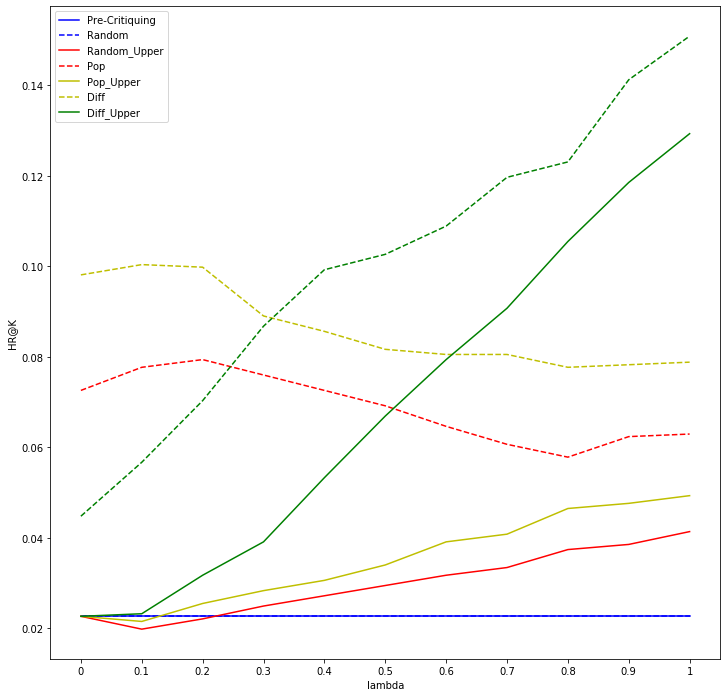

In [316]:
plot_lambda_vs_performance(df, k = 15, show = True, savefig = False)

# Visualization 

### Load experiment res

In [26]:
df = pd.read_csv(single_step_with_avg_path+"50user.csv")

In [27]:
df

,Unnamed: 0,user_id,target_item,item_name,iter,pre_rank,top_prediction_item_name,post_rank_random_all,post_rank_random_upper,post_rank_pop_all,post_rank_pop_upper,post_rank_diff_all,post_rank_diff_upper,critiqued_keyphrase_random,keyphrase_name_random,critiqued_keyphrase_pop,keyphrase_name_pop,critiqued_keyphrase_diff,keyphrase_name_diff,num_existing_keyphrases
0,0,300,101,b'Cabin Fever',0,3311,b'Khao San Road',"[3311, 3536, 2960, 3115, 3546, 3465, 3482, 345...","[2908, 2907, 2903, 2907, 2822, 2812, 2822, 282...","[3311, 3536, 2960, 3115, 3546, 3465, 3482, 345...","[2908, 2907, 2903, 2907, 2822, 2812, 2822, 282...","[3311, 2943, 3521, 3859, 3428, 3601, 3985, 347...","[3113, 3582, 3242, 3502, 3391, 2973, 4389, 260...",105,latte,105,latte,153,friendly,NaN
1,1,300,886,b'Wok & Roast Chinese BBQ',0,755,b'Khao San Road',"[755, 740, 632, 600, 522, 662, 688, 769, 858, ...","[145, 152, 139, 144, 151, 187, 190, 207, 226, ...","[755, 765, 773, 371, 268, 246, 301, 249, 224, ...","[10, 8, 12, 8, 10, 11, 15, 15, 14, 14, 14]","[755, 795, 473, 424, 445, 873, 811, 815, 830, ...","[237, 245, 172, 164, 182, 304, 287, 278, 285, ...",115,lobster,223,general tao,27,bbq,NaN
2,2,300,886,b'Wok & Roast Chinese BBQ',1,755,b'Khao San Road',"[755, 784, 875, 945, 2129, 2197, 2027, 3059, 4...","[241, 256, 301, 325, 569, 588, 585, 2340, 2329...","[755, 774, 780, 765, 816, 939, 1076, 1842, 202...","[48, 60, 66, 77, 91, 108, 121, 143, 150, 2247,...","[755, 758, 732, 439, 434, 481, 515, 731, 387, ...","[256, 263, 269, 184, 207, 260, 294, 394, 256, ...",48,burger,73,congee,0,chinese,NaN
3,3,300,886,b'Wok & Roast Chinese BBQ',2,755,b'Khao San Road',"[755, 830, 928, 2045, 1916, 1962, 4303, 3101, ...","[171, 193, 213, 313, 301, 311, 2240, 2239, 224...","[755, 784, 783, 756, 885, 1874, 2967, 2934, 29...","[139, 160, 158, 157, 188, 293, 2205, 2264, 223...","[755, 772, 795, 882, 583, 575, 2054, 1798, 167...","[379, 385, 396, 447, 340, 350, 883, 804, 781, ...",108,duck,60,squid,51,pork,NaN
4,4,300,886,b'Wok & Roast Chinese BBQ',3,755,b'Khao San Road',"[755, 819, 906, 944, 1364, 2166, 2105, 1946, 1...","[141, 163, 179, 206, 255, 320, 316, 320, 328, ...","[755, 819, 906, 944, 1364, 2166, 2105, 1946, 1...","[141, 163, 179, 206, 255, 320, 316, 320, 328, ...","[755, 787, 747, 690, 976, 936, 990, 1173, 1484...","[478, 520, 494, 457, 623, 619, 641, 696, 836, ...",72,scallop,72,scallop,5,fried,NaN
5,5,300,886,b'Wok & Roast Chinese BBQ',4,755,b'Khao San Road',"[755, 765, 773, 371, 268, 246, 301, 249, 224, ...","[10, 8, 12, 8, 10, 11, 15, 15, 14, 14, 14]","[755, 740, 632, 600, 522, 662, 688, 769, 858, ...","[145, 152, 139, 144, 151, 187, 190, 207, 226, ...","[755, 774, 717, 396, 120, 77, 70, 26, 30, 48, 68]","[105, 110, 101, 61, 24, 19, 20, 10, 11, 15, 24]",223,general tao,115,lobster,133,fried rice,NaN
6,6,300,886,b'Wok & Roast Chinese BBQ',5,755,b'Khao San Road',"[755, 774, 780, 765, 816, 939, 1076, 1842, 202...","[48, 60, 66, 77, 91, 108, 121, 143, 150, 2247,...","[755, 830, 928, 2045, 1916, 1962, 4303, 3101, ...","[171, 193, 213, 313, 301, 311, 2240, 2239, 224...","[755, 832, 917, 1065, 1916, 3425, 3392, 3480, ...","[265, 318, 350, 435, 698, 2482, 2480, 2456, 24...",73,congee,108,duck,54,noodle,NaN
7,7,300,886,b'Wok & Roast Chinese BBQ',6,755,b'Khao San Road',"[755, 837, 906, 1024, 1097, 1511, 1428, 1404, ...","[285, 311, 342, 389, 409, 471, 477, 473, 505, ...","[755, 865, 1044, 1116, 2032, 3756, 3720, 3065,...","[139, 179, 264, 323, 510, 2321, 2350, 2297, 22...","[755, 784, 783, 756, 885, 1874, 2967, 2934, 29...","[139, 160, 158, 157, 188, 293, 2205, 2264, 223...",59,ice cream,145,markham,60,squid,NaN
8,8,300,886,b'Wok & Roast Chinese BBQ',7,755,b'Khao San Road',"[755, 784, 783, 756, 885, 1874, 2967, 2934, 29...","[139, 160, 158, 157, 188, 293, 2205, 2264, 223...","[755, 795, 473, 424, 445, 873, 811, 815, 830, ...","[237, 245, 172, 164, 182, 304, 287, 278, 285, ...","[755, 774, 780, 765, 816, 939, 1076, 1842, 202...","[48, 60, 66, 77, 91, 108, 121, 143, 150, 2247,...",60,sq

In [29]:
literal_eval(df['post_rank_random_all'][0])

[3311, 3536, 2960, 3115, 3546, 3465, 3482, 3457, 2670, 3471, 2642]

In [11]:
df['post_rank_random_all'].values.tolist()

['[3311, 3536, 2960, 3115, 3546, 3465, 3482, 3457, 2670, 3471, 2642]',
 '[755, 740, 632, 600, 522, 662, 688, 769, 858, 929, 973]',
 '[755, 784, 875, 945, 2129, 2197, 2027, 3059, 4151, 4140, 2975]',
 '[755, 830, 928, 2045, 1916, 1962, 4303, 3101, 3083, 3054, 3098]',
 '[755, 819, 906, 944, 1364, 2166, 2105, 1946, 1955, 1933, 1923]',
 '[755, 765, 773, 371, 268, 246, 301, 249, 224, 196, 176]',
 '[755, 774, 780, 765, 816, 939, 1076, 1842, 2024, 4499, 3288]',
 '[755, 837, 906, 1024, 1097, 1511, 1428, 1404, 1497, 1555, 2936]',
 '[755, 784, 783, 756, 885, 1874, 2967, 2934, 2901, 2919, 2903]',
 '[755, 865, 1044, 1116, 2032, 3756, 3720, 3065, 3047, 3055, 3023]',
 '[755, 795, 473, 424, 445, 873, 811, 815, 830, 847, 866]',
 '[574, 586, 623, 686, 588, 607, 866, 818, 794, 797, 393]',
 '[574, 559, 548, 550, 492, 501, 533, 255, 254, 319, 320]',
 '[574, 372, 387, 430, 738, 1889, 3329, 3220, 3385, 2510, 3322]',
 '[574, 569, 566, 368, 272, 273, 203, 143, 175, 165, 146]',
 '[574, 625, 383, 436, 439, 420, 

### Plot HR vs. Performance for 3 keyphrase selection method

In [297]:
# Get post rank hr_k with different lambda values
def get_post_rank(df,rank_type = 'random_all', line = 0):
    """
    get one line of the post_rank res
    """
    return np.array(literal_eval(df['post_rank_'+rank_type][line])).reshape(1,11)

def concat_rank(df,rank_type = 'random_all'):
    """
    concat all post_rank res to one matrix
    """
    res = get_post_rank(df, rank_type=rank_type, line = 0)
    for i in range(1,len(df)):
        res = np.concatenate((res,get_post_rank(df, rank_type=rank_type, line = i)))
    return res

def get_post_hr_at_k(df, k, rank_type = 'random_all'):
    """
    Get hr_at_k for rank_type
    return a numpy array of length 11 corresponding to each lambda value 
    """
    ranks = concat_rank(df,rank_type = rank_type) # concat the experiment result for rank_type

    hr_at_k = np.where(ranks<k)[1] # compare rank with k
    count = np.unique(hr_at_k, return_counts=True) # get count for each lambda value

    return count[1]/len(df) 

def get_pre_hr_at_k(df, k, pre_col = 'pre_rank'):
    pre_hit = len(np.where(df[pre_col]<k)[0])
    return pre_hit/len(df)

In [300]:
def plot_lambda_vs_performance(df, k = 25, show = True, savefig = False):
    """get hr@k graph for all 6 options
    x_axis: lambda from all initial to all modified matrix
    y_axis: performance (hr@k)"""
    plt.figure(figsize=(12,12))
    # Get lines
    pre_hr = [get_pre_hr_at_k(df,k,pre_col = 'pre_rank')]*11 # repeat len(lams) times
    pruned_hr = [get_pre_hr_at_k(df,k,pre_col = 'pure_pruning_rank')]*11 # repeat len(lams) times
    random_all = get_post_hr_at_k(df,k,rank_type='random_all')
    random_upper = get_post_hr_at_k(df,k,rank_type='random_upper')
    pop_all = get_post_hr_at_k(df,k,rank_type='pop_all')
    pop_upper = get_post_hr_at_k(df,k,rank_type='pop_upper')
    diff_all = get_post_hr_at_k(df,k,rank_type='diff_all')
    diff_upper = get_post_hr_at_k(df,k,rank_type='diff_upper')

    plt.plot(np.arange(11), pre_hr,'b')
    plt.plot(np.arange(11), pruned_hr,'b--')
    plt.plot(np.arange(11), random_all,'r-')
    plt.plot(np.arange(11), random_upper,'r--')
    plt.plot(np.arange(11), pop_all,'y-')
    plt.plot(np.arange(11), pop_upper,'y--')
    plt.plot(np.arange(11), diff_all,'g-')
    plt.plot(np.arange(11), diff_upper,'g--')

    x = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    xi = list(range(len(x)))
    # plt.xticks(np.arange(len(k_list)), k_list)
    plt.xlabel('lambda')
    plt.ylabel('HR@K')
    plt.legend(['Pre-Critiquing','Random', 'Random_Upper','Pop','Pop_Upper','Diff','Diff_Upper'])
    plt.xticks(xi, x)
    if show == True:
        plt.show()
    if savefig == True:
        plt.savefig('../figs/three_keyphrase_selection_methods_with_upper_bound_0115_hr15')

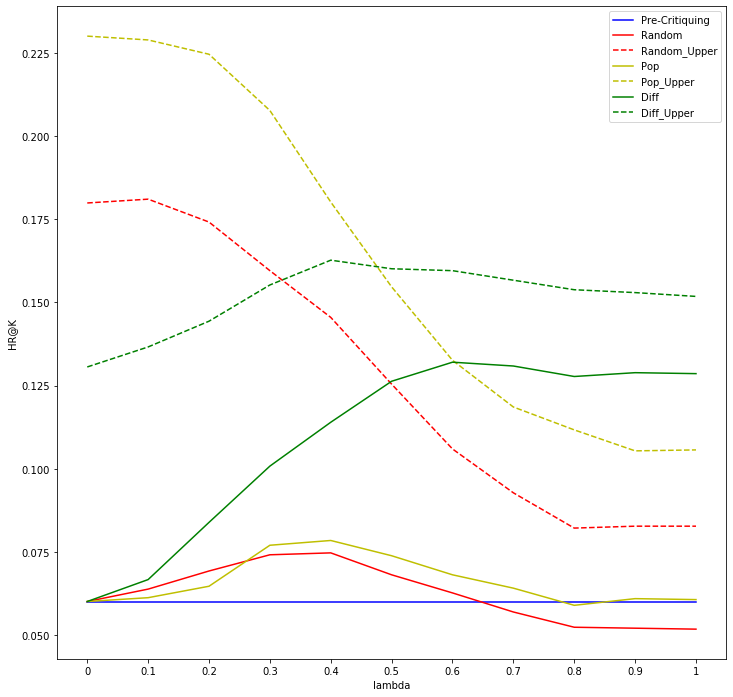

In [156]:
plot_lambda_vs_performance(df, k = 25)

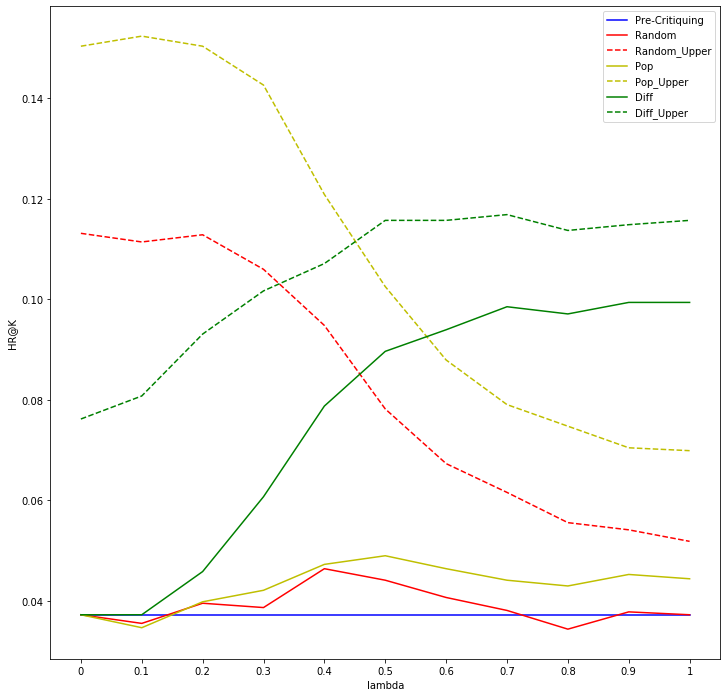

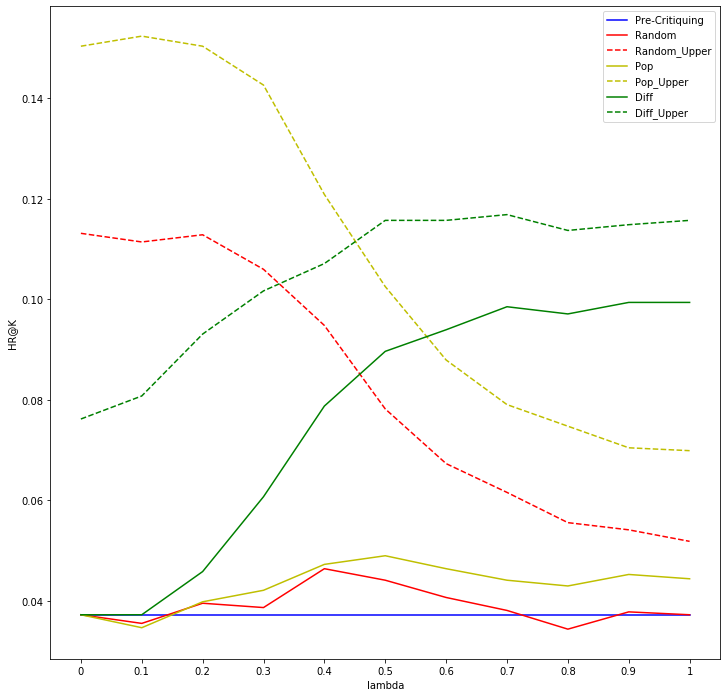

In [162]:
plot_lambda_vs_performance(df, k = 15)

In [41]:



def hr_at_k(df, k):
    pre_hit = np.where(df['pre_rank']<k)[0]
    post_hit = np.where(df['post_rank']<k)[0]


def hr_at_k(df, k):
    """
    Given the above dataframe, calculate the avg pre and post hit rate at k 
    """
    pre_hit = np.where(df['pre_rank']<k)[0]
    post_hit = np.where(df['post_rank']<k)[0]
    pre_hr = len(pre_hit)/len(df)
    post_hr = len(post_hit)/len(df)
    return pre_hr, post_hr

In [66]:
# Utlilty func
def hr_at_k(df, k):
    """
    Given the above dataframe, calculate the avg pre and post hit rate at k 
    """
    pre_hit = np.where(df['pre_rank']<k)[0]
    post_hit = np.where(df['post_rank']<k)[0]
    pre_hr = len(pre_hit)/len(df)
    post_hr = len(post_hit)/len(df)
    return pre_hr, post_hr

def get_hr(l=5, rang = 200):
    """
    Get the hit rate at different rang, with different lambda value
    Output in the form of list
    """
    pre_hr_list = []
    post_hr_list = []
    for k in range(1,rang):
        pre_hr,post_hr = hr_at_k(df,4, k)
        pre_hr_list.append(pre_hr)
        post_hr_list.append(post_hr)
    return pre_hr_list,post_hr_list

def get_hr_of_all_lambda(methods):
    for method in methods:
        post_rates = []
        for i in range(9):
            _,a = get_hr(l=i)
            diff.append(a)

In [ ]:
pre_hr_list,b = get_hr(l=5)

In [ ]:
def plot_hr_performance():
    plt.figure(figsize=(12,12))
    for 
    plt.plot(np.arange(len(pre_hr_list)), pre_hr_list)
    plt.plot(np.arange(len(pre_hr_list)), a1)
    plt.plot(np.arange(len(pre_hr_list)), a2)
    plt.plot(np.arange(len(pre_hr_list)), a3)
    plt.plot(np.arange(len(pre_hr_list)), a4)
    plt.plot(np.arange(len(pre_hr_list)), a5)
    plt.plot(np.arange(len(pre_hr_list)), a6)

    # plt.xticks(np.arange(len(k_list)), k_list)
    plt.xlabel('k')
    plt.ylabel('HR@K')
    plt.legend(['Pre-Critiquing','Random', 'Random_Upper','Pop','Pop_Upper','Diff','Diff_Upper'])
    plt.show()
    plt.savefig('../figs/three_keyphrase_selection_methods_with_upper_bound_0104')